In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets

import numpy as np
import seaborn as sns
import random

from PIL import Image, ImageChops

In [2]:
import subprocess
import numpy as np

def load_audio_ffmpeg(path, sr=22050):
    cmd = [
        "ffmpeg",
        "-i", path,
        "-f", "f32le",
        "-acodec", "pcm_f32le",
        "-ac", "1",
        "-ar", str(sr),
        "-"
    ]

    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    raw_audio = p.stdout.read()
    audio = np.frombuffer(raw_audio, dtype=np.float32)

    return audio, sr


In [3]:

def split_audio(audio, sr, window_sec=10, overlap=0.5):
    """
    Split audio into overlapping windows.

    audio: np.ndarray
    sr: sample rate
    window_sec: window length in seconds
    overlap: fraction overlap between windows (0 to <1)
    """
    window_len = int(window_sec * sr)
    stride = int(window_len * (1 - overlap))

    chunks = []
    for start in range(0, len(audio) - window_len + 1, stride):
        chunk = audio[start:start + window_len]
        chunks.append(chunk)

    return chunks


In [4]:
import librosa

def audio_chunk_to_mel(chunk, sr, n_mels=128, n_fft=2048, hop_length=512):
    mel = librosa.feature.melspectrogram(
        y=chunk,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalize per chunk
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

    return mel_db


Common sample rates <br>
Sample rate	Used for: <br>
8000 Hz	Telephone speech <br>
16000 Hz	ASR, speech models <br>
22050 Hz	Music ML (librosa default) <br>
44100 Hz	CD audio <br>
48000 Hz	Video / pro audio <br>


Why 22050 is common in ML <br>
Because: <br>
Human hearing tops out at ~20kHz <br>
Nyquist theorem → need ≥40kHz <br>
22050 is a computationally cheap compromise <br>
Keeps enough musical detail <br>

In [5]:
audio, sr = librosa.load("/Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/genres_original/blues/blues.00000.wav", sr=22050)

# audio, sr = load_audio_ffmpeg(path)
'''
Librosa.load():
Opens the audio file from disk
Decodes compressed formats (wav, mp3, flac, etc.)
Converts it into a waveform array (np.ndarray)
Resamples it to 22050 Hz
Normalizes amplitude to [-1, 1]
Converts stereo → mono (by default)
'''

chunks = split_audio(audio, sr, window_sec=10, overlap=0.5)

total = 0

for c in chunks:
    print(type(c))
    total += len(c)

print(total) # 5 × 220,500 = 1,102,500

print(type(chunks))
print(len(chunks))
print(chunks[0].shape)
print(chunks)


print("sr:", sr)        # 22050
print("no of samples:", len(audio))  # number of samples
print("length:", len(audio) / sr)  # duration in seconds



<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1102500
<class 'list'>
5
(220500,)
[array([0.00732422, 0.01660156, 0.00762939, ..., 0.07623291, 0.07675171,
       0.08129883], shape=(220500,), dtype=float32), array([-0.13705444, -0.16964722, -0.19995117, ..., -0.07147217,
       -0.00927734,  0.06085205], shape=(220500,), dtype=float32), array([ 0.08428955,  0.0763855 ,  0.06439209, ..., -0.06655884,
       -0.13565063, -0.07778931], shape=(220500,), dtype=float32), array([ 0.10098267,  0.09442139,  0.05526733, ..., -0.00894165,
       -0.00601196,  0.01730347], shape=(220500,), dtype=float32), array([-0.02139282, -0.0869751 , -0.04486084, ...,  0.18188477,
        0.1637268 ,  0.15093994], shape=(220500,), dtype=float32)]
sr: 22050
no of samples: 661794
length: 30.013333333333332


In [6]:
import librosa

def audio_to_mel_chunks(
    path,
    window_sec=10,
    overlap=0.5,
    sr=22050,
    n_mels=128,
    n_fft=2048,
    hop_length=512
):
    audio, sr = librosa.load(path, sr=sr)

    chunks = split_audio(audio, sr, window_sec, overlap)
    mels = [audio_chunk_to_mel(c, sr, n_mels, n_fft, hop_length) for c in chunks]

    return mels  # list of (n_mels, time)


In [7]:
audio, sr = librosa.load("/Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/genres_original/blues/blues.00000.wav", sr=22050)
chunks = split_audio(audio, sr, window_sec=10, overlap=0.5)
print(len(chunks))  # ~5 for 30s audio


5


In [8]:
import matplotlib.pyplot as plt
import librosa.display

def show_mel(mel, sr=22050, hop_length=512, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        mel,
        sr=sr,
        hop_length=hop_length,
        # x_axis='time',
        # y_axis='mel',
        cmap = "inferno" # try: 'viridis', 'inferno', 'plasma', 'coolwarm'
    )
    # plt.colorbar(format="%+2.0f dB")
    # plt.title(title)
    # plt.tight_layout()
    plt.show()



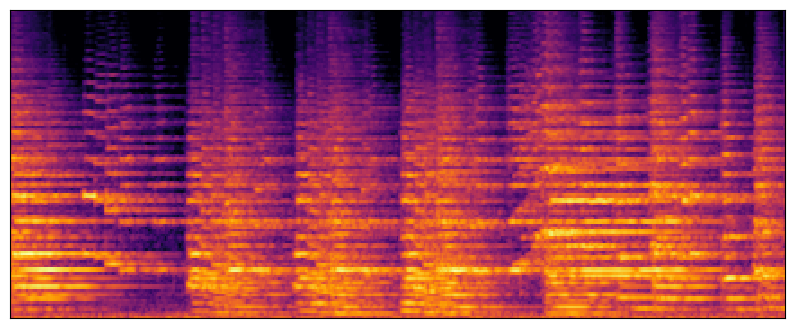

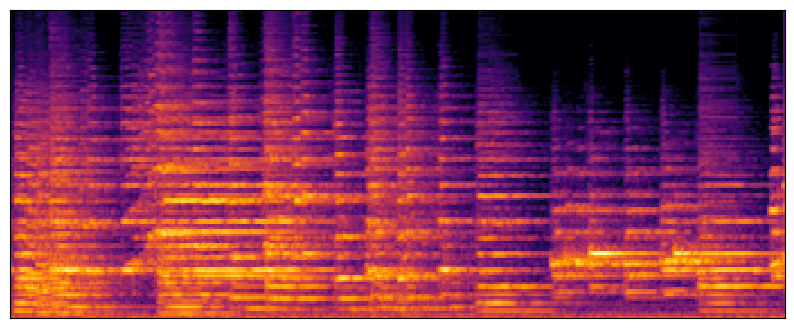

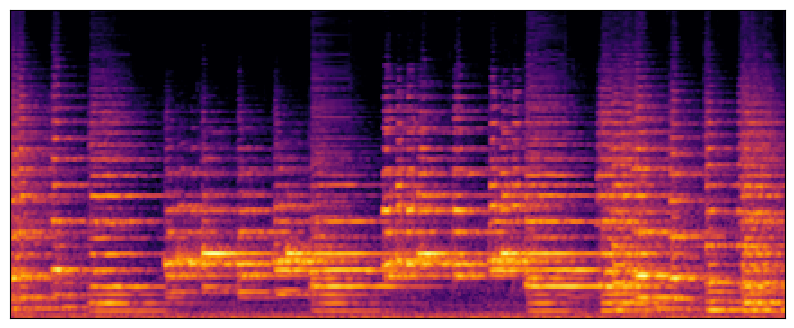

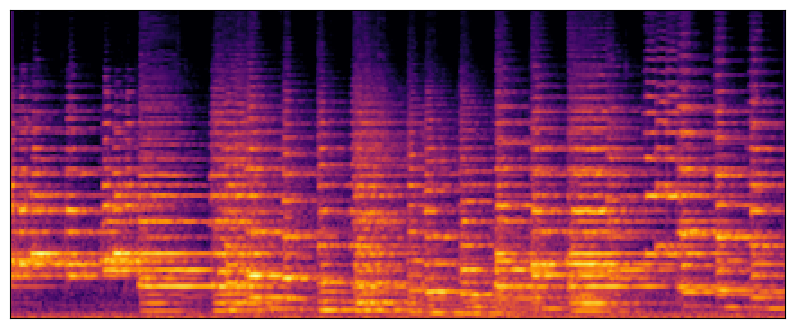

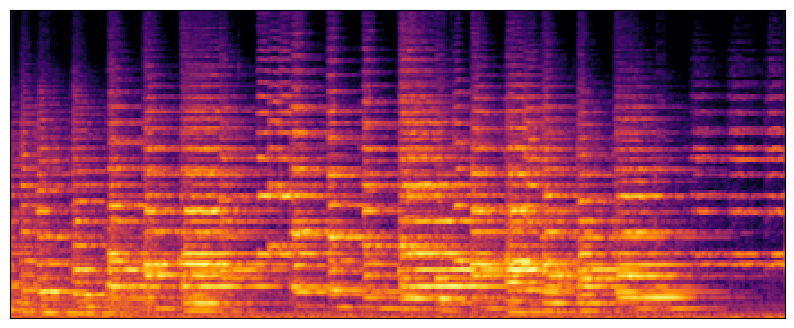

In [9]:
view = audio_to_mel_chunks("/Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/genres_original/classical/classical.00073.wav", sr=22050)
# show_mel(view[0])
for i, mel in enumerate(view):
    show_mel(mel, title=f"Chunk {i+1}")

In [10]:
import os

def list_audio_files(root):
    files = []
    labels = []

    for genre in sorted(os.listdir(root)):
        folder = os.path.join(root, genre)
        if not os.path.isdir(folder):
            continue

        for f in sorted(os.listdir(folder)):
            if f.endswith(".wav"):
                files.append(os.path.join(folder, f))
                labels.append(genre)

    return files, labels


In [11]:
def build_spectrogram_dataset(files, labels):
    X = []
    y = []

    for path, label in zip(files, labels):
        try:
            mels = audio_to_mel_chunks(path)
        except Exception as e:
            print("FAILED:", path, e)

        for mel in mels:
            X.append(mel)
            y.append(label)

    return X, y


In [12]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(y):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    return y_enc, le


In [13]:
def to_numpy(X, y):
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y


In [14]:
class SpectrogramDataset(Dataset):
    def __init__(self, X, y):
        self.X = t.tensor(X)
        self.y = t.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(0), self.y[idx]


In [15]:
from sklearn.model_selection import train_test_split

ROOT = "/Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/genres_original"

files, labels = list_audio_files(ROOT)
X, y = build_spectrogram_dataset(files, labels)
y_enc, le = encode_labels(y)
X, y_enc = to_numpy(X, y_enc)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

train_ds = SpectrogramDataset(X_train, y_train)
val_ds   = SpectrogramDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


/var/folders/1n/7vsjyk_92kx6ct8jj46wx6p80000gp/T/ipykernel_97366/2578634030.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(path, sr=sr)
/Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/.venv/lib/python3.14/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FAILED: /Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/genres_original/jazz/jazz.00054.wav 


In [16]:
import soundfile as sf

path = "/Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/genres_original/blues/blues.00000.wav"

try:
    data, sr = sf.read(path)
    print("soundfile succeeded:", data.shape, sr)
except Exception as e:
    print("soundfile failed:", e)


soundfile succeeded: (661794,) 22050


In [17]:
class VGG_net(nn.Module):
    def __init__(self):
        super(VGG_net, self).__init__()

        def block(input, output):
            return nn.Sequential(
                nn.Conv2d(input, output, 3, 1, 1),
                nn.ReLU(),
                nn.Conv2d(output, output, 3, 1, 1),
                nn.ReLU(),
                nn.BatchNorm2d(output),
                nn.MaxPool2d(2)
            )

        self.block1 = block(1, 32)
        self.block2 = block(32, 64)
        self.block3 = block(64, 128)
        self.block4 = block(128, 256)
        self.block5 = block(256, 256)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [18]:
model = VGG_net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
device = t.device("mps" if t.backends.mps.is_available() else "cpu")
model.to(device)
device

device(type='mps')

In [19]:
model.block1(t.rand([32, 1, 128, 431]).to(device)).shape
model.block2(t.rand([32, 32, 64, 215]).to(device)).shape
model.block3(t.rand([32, 64, 32, 107]).to(device)).shape
model.block4(t.rand([32, 128, 16, 53]).to(device)).shape

torch.Size([32, 256, 8, 26])

In [20]:
epochs = 50
cost_hist = []

for i in range(epochs):

    # ---- Training ----
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = t.max(output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    cost_hist.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    correct_dev, total_dev = 0, 0
    dev_loss = 0

    with t.no_grad():
        for images_d, labels_d in val_loader:
            images_d, labels_d = images_d.to(device), labels_d.to(device)
            output_d = model(images_d)
            loss_d = criterion(output_d, labels_d)

            dev_loss += loss_d.item()
            _, predicted_d = t.max(output_d, 1)
            total_dev += labels_d.size(0)
            correct_dev += (predicted_d == labels_d).sum().item()

    avg_dev_loss = dev_loss / len(val_loader)
    dev_acc = 100 * correct_dev / total_dev

    print(f"Epoch {i+1:02d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {avg_dev_loss:.4f} | Val Acc: {dev_acc:.2f}%")


Epoch 01 | Train Loss: 1.5676 | Train Acc: 40.03% | Val Loss: 1.7798 | Val Acc: 39.34%
Epoch 02 | Train Loss: 1.2174 | Train Acc: 56.36% | Val Loss: 1.3504 | Val Acc: 52.85%
Epoch 03 | Train Loss: 0.9770 | Train Acc: 66.51% | Val Loss: 1.8021 | Val Acc: 41.34%
Epoch 04 | Train Loss: 0.8012 | Train Acc: 72.85% | Val Loss: 0.9658 | Val Acc: 65.57%
Epoch 05 | Train Loss: 0.6858 | Train Acc: 76.93% | Val Loss: 0.8213 | Val Acc: 73.07%
Epoch 06 | Train Loss: 0.6041 | Train Acc: 79.86% | Val Loss: 0.7323 | Val Acc: 75.38%
Epoch 07 | Train Loss: 0.5279 | Train Acc: 82.44% | Val Loss: 1.5439 | Val Acc: 60.86%
Epoch 08 | Train Loss: 0.4864 | Train Acc: 83.52% | Val Loss: 1.0990 | Val Acc: 69.87%
Epoch 09 | Train Loss: 0.4230 | Train Acc: 85.62% | Val Loss: 1.3335 | Val Acc: 62.56%
Epoch 10 | Train Loss: 0.4119 | Train Acc: 85.95% | Val Loss: 0.9971 | Val Acc: 71.87%
Epoch 11 | Train Loss: 0.3468 | Train Acc: 88.30% | Val Loss: 0.5168 | Val Acc: 83.28%
Epoch 12 | Train Loss: 0.3012 | Train Acc: 

<Axes: >

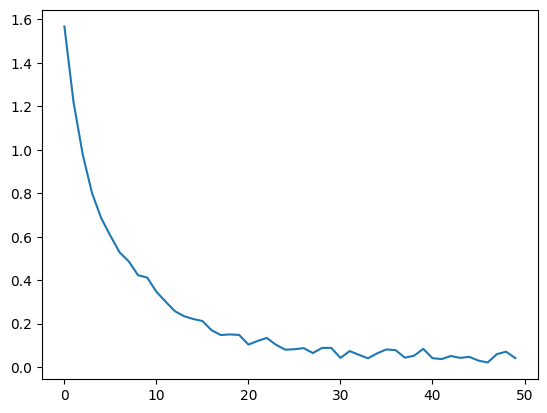

In [21]:
sns.lineplot(x = range(len(cost_hist)), y = cost_hist)

In [22]:
import librosa

def audio_to_mel_chunks_test(
    path,
    window_sec=3,
    overlap=0,
    sr=22050,
    n_mels=128,
    n_fft=2048,
    hop_length=512
):
    audio, sr = librosa.load(path, sr=sr)

    chunks = split_audio(audio, sr, window_sec, overlap)
    mels = [audio_chunk_to_mel(c, sr, n_mels, n_fft, hop_length) for c in chunks]

    return mels  # list of (n_mels, time)

In [23]:
import torch

@torch.no_grad()
def predict_with_chunks(model, audio_path, device):
    mels = audio_to_mel_chunks_test(audio_path, window_sec=10, overlap=0.5)
    probs_sum = None

    for mel in mels:
        mel_tensor = torch.tensor(mel, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        logits = model(mel_tensor)
        probs = torch.softmax(logits, dim=1)

        if probs_sum is None:
            probs_sum = probs
        else:
            probs_sum += probs

    avg_probs = probs_sum / len(mels)
    pred = avg_probs.argmax(dim=1).item()
    conf = avg_probs.max().item()

    return pred, conf

In [24]:
import librosa

def audio_chunk_to_mel(chunk, sr, n_mels=128, n_fft=2048, hop_length=512):
    mel = librosa.feature.melspectrogram(
        y=chunk,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalize per chunk
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

    return mel_db


In [25]:
a


NameError: name 'a' is not defined

In [ ]:
predict_with_chunks(model, "/Users/abhin-zstch1563/Documents/AI/DL/CNN/instruments/music_dataset/Electro_Guitar/5.wav", device)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [26]:
t.save(model.state_dict(), "my_best_model.pth")


In [ ]:
import sys
print(sys.executable)


/opt/homebrew/opt/python@3.11/bin/python3.11


In [ ]:
import numpy as np
import librosa
import soundfile as sf

print("NumPy:", np.__version__)
print("librosa:", librosa.__version__)
print("soundfile:", sf.__version__)


NumPy: 2.3.5
librosa: 0.11.0
soundfile: 0.13.1


In [ ]:
import numpy as np
print(np.__version__)


2.2.6


In [ ]:
import sys
print(sys.executable)


/usr/local/bin/python3


In [ ]:
import sys, numpy, librosa
print(sys.executable)
print(numpy.__version__)
print(librosa.__version__)


/Users/abhin-zstch1563/Documents/AI/DL/CNN/music_genre/.venv/bin/python
2.2.0
0.11.0
